# Projeto Final de Ciência dos Dados. ( PkmnID)

## Algoritmo de predição da categoria de Pokémons por meio de suas imagens.
### O algoritmo realiza a extração e a clusterização de features de imagens por meio do método \"Bag of Visual Words\" (BOVW),classifica-as utilizando o método de machine learning \"Random Forest\" e prevê a categoria de Pokémons por meio de novas imagens.

In [29]:
!pip install opencv-contrib-python
import cv2
import os
import os.path
import numpy as np
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from pprint import pprint

np.random.seed(0)

## 1- Extração de features de imagens: Bag of Visual Words
### Uma vez que o dataset se trata de um conjunto de imagens de diferentes Pokémons, é necessário inicialmente extrair features dessas imagens, através do método "Bag of Visual Words".
### Com as imagens transformadas em features clusterizadas, elas são separadas em categorias de treino e teste, que serão utilizadas posteriormente pelo algoritmo de machine learning.
### O código abaixo realiza essas duas etapas:
#### Obs: Código produzido com a assistência do Prof. Fábio Ayres

In [30]:
TRAIN_DIR = 'Assets//Data_Train'
TEST_DIR = 'Assets//Data_Test'

NUM_CLUSTERS = 40

TRAIN_IMG = []
TEST_IMG = []
TRAIN_LABEL = []
TEST_LABEL = []

for train, test in zip(os.listdir(TRAIN_DIR), os.listdir(TEST_DIR)): #Tecnicamente são iguais, mas não custa garantir.
    for img_train, img_test in zip(os.listdir(os.path.join(TRAIN_DIR,train)), os.listdir(os.path.join(TEST_DIR,test))):
        TRAIN_IMG.append(os.path.join(TRAIN_DIR,train,img_train))
        TEST_IMG.append(os.path.join(TEST_DIR,test,img_test))
        TRAIN_LABEL.append(train)
        TEST_LABEL.append(test)


def cria_vocabulario(imagens, num_clusters):
    km = cv2.BOWKMeansTrainer(num_clusters)
    akaze = cv2.KAZE_create()
    for p in imagens:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        mask = np.ones(img.shape)
        kp, desc = akaze.detectAndCompute(img, mask)
        km.add(desc)
    return km.cluster()

def representa(vocab, img):
    kaze = cv2.KAZE_create()
    kp = kaze.detect(img)
    bowdesc = cv2.BOWImgDescriptorExtractor(kaze, cv2.FlannBasedMatcher())
    bowdesc.setVocabulary(vocab)
    return bowdesc.compute(img, kp)

def transforma_imagens(imagens, vocab):
    X = []
    for p in imagens:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        X.append(representa(vocab, img).flatten())
    return np.array(X)


vocab = cria_vocabulario(TRAIN_IMG, NUM_CLUSTERS)
X_train = transforma_imagens(TRAIN_IMG, vocab)
X_test = transforma_imagens(TEST_IMG, vocab)
y_train = TRAIN_LABEL
y_test = TEST_LABEL

In [57]:
def show_example(path = "Testes/Testes/Arbok.png", Plot = True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, dsize=(120, 120))
    if Plot:
        plt.imshow(img_resized, cmap='gray', vmin=0, vmax=255)
    return representa(vocab, img_resized)

## 2 - Análise Exploratória:
### Para realizar a análise exploratória seguiremos alguns passos:
### 2.1 - Extrair histograma:
### O código abaixo cria o histograma de frequências relativas das features de todas as imagens do dataset escolhido."

In [32]:
origin_dir = 'Assets//Data_Filtered_Resized'
Hist_Dict = {}
for pkmn in os.listdir(origin_dir):
    Hist_Dict[pkmn] = []
    current_dir = os.path.join(origin_dir,pkmn)
    for k, img in enumerate(os.listdir(current_dir)):
        Hist_Dict[pkmn].append(show_example(os.path.join(current_dir,img), Plot = False))
# print(Hist_Dict['Alakazam'])

## 2.2 - Criar um dataframe para trabalhar melhor com o dataset:

In [33]:
lista = []
lista_nomes = os.listdir('Assets/Data_Filtered_Resized')
for k in Hist_Dict:
    x = pd.Series(Hist_Dict[k]).mean()
    x = pd.Series(x[0])
    lista.append(x)
df_medias = pd.DataFrame(lista, index = lista_nomes)

## Tabela das frequências relativas médias de cada feature por pokémon:

In [34]:
df_medias.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Aerodactyl,0.078169,0.022500,0.015632,0.005098,0.031040,0.005579,0.037082,0.041625,0.007602,0.025657,...,0.026346,0.009593,0.009131,0.039864,0.038997,0.013546,0.026383,0.004830,0.051151,0.022073
Arbok,0.046870,0.018808,0.018613,0.031273,0.025666,0.014857,0.028470,0.031916,0.025414,0.053709,...,0.013678,0.015478,0.014899,0.021721,0.016145,0.094164,0.037441,0.011092,0.015090,0.030995
Arcanine,0.023507,0.054781,0.006560,0.020917,0.041971,0.005193,0.033877,0.025606,0.010007,0.033909,...,0.032335,0.010212,0.005588,0.033036,0.021843,0.022807,0.040144,0.004119,0.012807,0.036101
Beedrill,0.034809,0.042323,0.012216,0.013263,0.038851,0.004541,0.038670,0.038596,0.006013,0.014829,...,0.024981,0.012205,0.009617,0.055877,0.016568,0.012651,0.021113,0.003504,0.034361,0.027315
Bellsprout,0.024587,0.060073,0.013434,0.017563,0.037341,0.010970,0.017845,0.014788,0.012284,0.019897,...,0.042438,0.004958,0.013814,0.076745,0.022573,0.017935,0.015503,0.012349,0.014649,0.040954


## 2.3 - Calculando os valores médios dos dados:
### Nesta etapa foi calculado os valores médios dos dados, e em sequência foram aproximados do ponto (0,0), origem do sistema.

In [35]:
df_medias = df_medias - (1/40) 

In [36]:
df_medias.sum(axis=1)

Aerodactyl    2.980232e-08
Arbok         3.725290e-08
Arcanine     -1.862645e-09
Beedrill     -1.173466e-07
Bellsprout   -1.490116e-08
Bulbasaur     5.587935e-08
Charmander   -3.352761e-08
Jigglypuff    8.940697e-08
Meowth        0.000000e+00
Pidgey        5.774200e-08
Squirtle     -2.980232e-08
Voltorb       2.980232e-08
dtype: float32

In [37]:
normas = (df_medias*df_medias).sum(axis=1)
for m in normas.index:
    df_medias.loc[m] = df_medias.loc[m]/np.sqrt(normas[m])

## 2.4 - Comparação entre os Pokémons:
### Com base nos valores calculados anteriormente, foi criada a tabela seguinte, que mostra o quanto os Pokémons são semelhantes entre si, sendo 1 a semelhança máxima, e -1 o oposto.

In [38]:
df_compara = df_medias.dot(df_medias.transpose())
df_compara

,Aerodactyl,Arbok,Arcanine,Beedrill,Bellsprout,Bulbasaur,Charmander,Jigglypuff,Meowth,Pidgey,Squirtle,Voltorb
Aerodactyl,1.000000,0.238902,0.413008,0.695894,0.380622,0.104795,0.607457,0.145662,0.492351,0.508590,0.305381,0.319396
Arbok,0.238902,1.000000,0.432300,0.262570,0.194861,0.651814,0.404563,0.177014,0.197609,0.216998,0.515018,0.642744
Arcanine,0.413008,0.432300,1.000000,0.823387,0.790024,0.576141,0.702251,0.752163,0.865824,0.799934,0.915237,0.052726
Beedrill,0.695894,0.262570,0.823387,1.000000,0.758050,0.294246,0.675901,0.593348,0.850086,0.794570,0.706048,0.092733
Bellsprout,0.380622,0.194861,0.790024,0.758050,1.000000,0.200275,0.600427,0.698348,0.765476,0.723681,0.708249,0.005441
Bulbasaur,0.104795,0.651814,0.576141,0.294246,0.200275,1.000000,0.571292,0.480403,0.416695,0.412945,0.673993,0.414075
Charmander,0.607457,0.404563,0.702251,0.675901,0.600427,0.571292,1.000000,0.604894,0.656063,0.877117,0.819227,0.426163
Jigglypuff,0.145662,0.177014,0.752163,0.593348,0.698348,0.480403,0.604894,1.000000,0.711153,0.649298,0.742159,0.063552
Meowth,0.492351,0.197609,0.865824,0.850086,0.765476,0.416695,0.656063,0.711153,1.000000,0.737639,0.774470,-0.030745
Pidgey,0.508590,0.216998,0.799934,0.794570,0.723681,0.412945,0.877117,0.649298,0.737639,1.000000,0.833766,0.182581


### Podemos observar que alguns Pokémons possuem muitas semelhanças pois apresentam as mesmas features em abundância (na média)."

In [39]:
monstros = []
for feat in range(NUM_CLUSTERS):
    monstros.append(sorted(df_medias.nlargest(n=5, columns=[feat]).index) + [feat])
x = sorted(monstros)
pprint(x)

[['Aerodactyl', 'Arbok', 'Beedrill', 'Charmander', 'Voltorb', 0],
 ['Aerodactyl', 'Arbok', 'Bellsprout', 'Jigglypuff', 'Voltorb', 32],
 ['Aerodactyl', 'Arbok', 'Bulbasaur', 'Jigglypuff', 'Voltorb', 13],
 ['Aerodactyl', 'Arbok', 'Bulbasaur', 'Jigglypuff', 'Voltorb', 16],
 ['Aerodactyl', 'Arbok', 'Charmander', 'Squirtle', 'Voltorb', 2],
 ['Aerodactyl', 'Arcanine', 'Beedrill', 'Bulbasaur', 'Meowth', 6],
 ['Aerodactyl', 'Beedrill', 'Bellsprout', 'Charmander', 'Pidgey', 33],
 ['Aerodactyl', 'Beedrill', 'Bulbasaur', 'Charmander', 'Pidgey', 7],
 ['Aerodactyl', 'Beedrill', 'Charmander', 'Pidgey', 'Voltorb', 17],
 ['Aerodactyl', 'Beedrill', 'Charmander', 'Pidgey', 'Voltorb', 38],
 ['Aerodactyl', 'Bulbasaur', 'Charmander', 'Meowth', 'Pidgey', 29],
 ['Aerodactyl', 'Bulbasaur', 'Charmander', 'Meowth', 'Pidgey', 34],
 ['Aerodactyl', 'Charmander', 'Meowth', 'Pidgey', 'Voltorb', 21],
 ['Arbok', 'Arcanine', 'Beedrill', 'Bulbasaur', 'Squirtle', 14],
 ['Arbok', 'Arcanine', 'Beedrill', 'Meowth', 'Squirtl

### A soma das colunas da tabela anterior mostra quais Pokémons são mais difíceis de distinguir.

In [40]:
df_compara.sum(axis = 1).sort_values(ascending = False)

Squirtle      8.198668
Arcanine      8.122995
Charmander    7.945354
Pidgey        7.737120
Beedrill      7.546834
Meowth        7.436620
Bellsprout    6.825454
Jigglypuff    6.617992
Bulbasaur     5.796674
Aerodactyl    5.212059
Arbok         4.934393
Voltorb       3.373785
dtype: float32

## 3 - "Machine Learning" e Classificação:
### O método de aprendizado de máquina e classificação utilizado foi o "Random Forest Classifier".

In [41]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators = 100)
clf.fit(X_train, y_train)
scr = clf.score(X_test, y_test)

### Abaixo estão a acurácia do modelo, e a acurácia esperada caso a classificação fosse aleatória.

In [42]:
scr, 1/13

(0.49203187250996017, 0.07692307692307693)

## 3.1 - Análise das classificações realizadas pelo modelo:
### A matriz de confusão abaixo mostra em mais detalhes os erros e acertos do classificador. É possível identificar que na maioria das vezes que o modelo falhou, ele identificou erroneamente o Pokémon como sendo uma "Jigglypuff" ou um "Arcanine".

#### Obs: O código abaixo não é de nossa autoria, e sua versão original pode ser encontrada no seguinte endereço: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

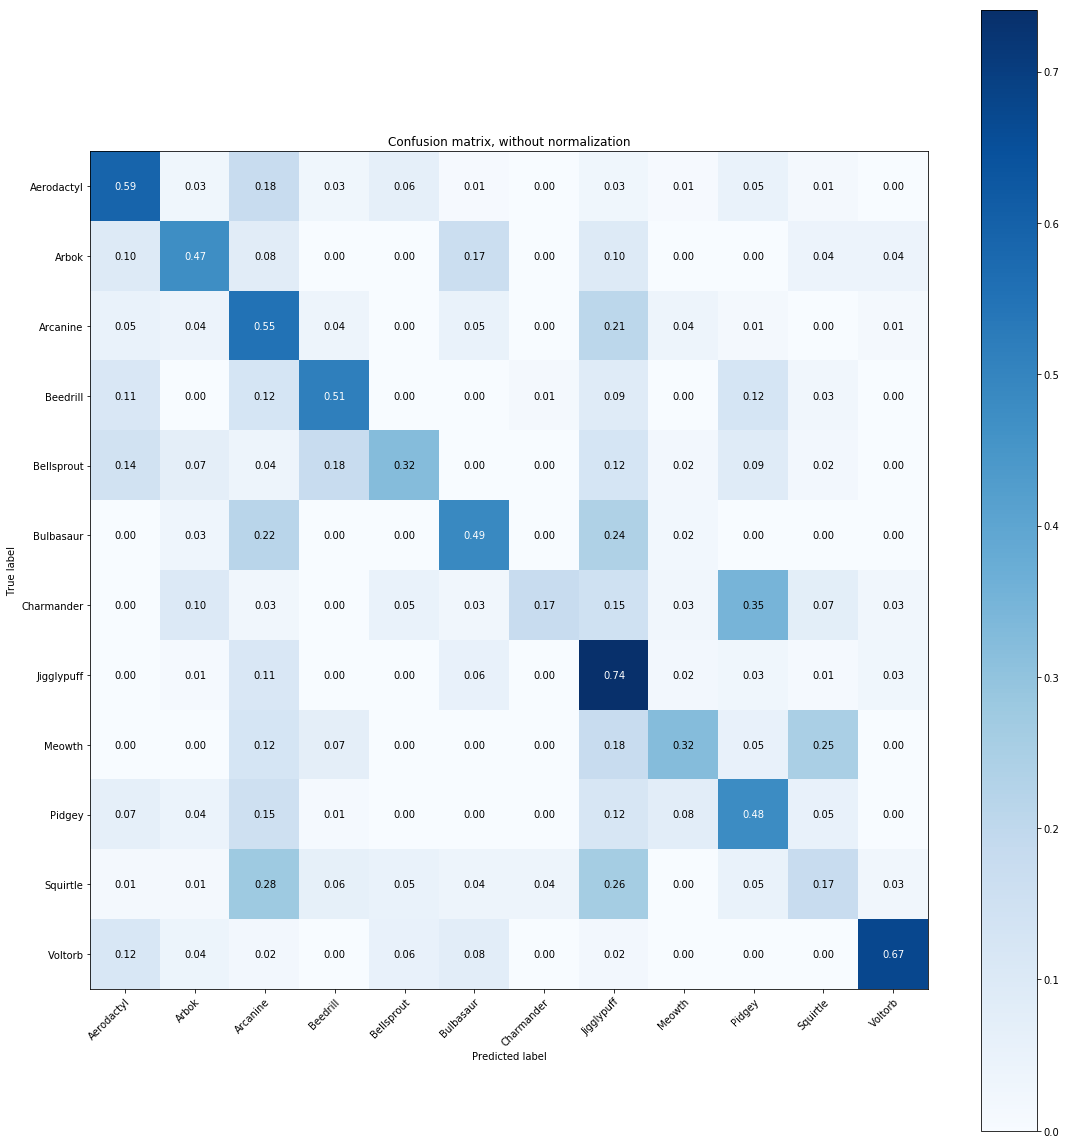

In [43]:
y_pred = clf.predict(X_test)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=clf.classes_,
                      title='Confusion matrix, without normalization')



plt.show()

In [44]:
hits, miss = 0, 0
for img, label in zip(TEST_IMG, TEST_LABEL):
    rep = representa(vocab, cv2.imread(img))
    top3 = pd.Series(clf.predict_proba(rep)[0], index = os.listdir('Assets/Data_Test')).nlargest(3)
    if label in top3.index.tolist():
        hits += 1
    else:
        miss += 1
        
hits, miss, hits/(hits+miss)

(744, 260, 0.7410358565737052)

Aerodactyl    0.07
Arbok         0.12
Arcanine      0.09
Beedrill      0.06
Bellsprout    0.06
Bulbasaur     0.16
Charmander    0.05
Jigglypuff    0.02
Meowth        0.03
Pidgey        0.08
Squirtle      0.14
Voltorb       0.12
dtype: float64

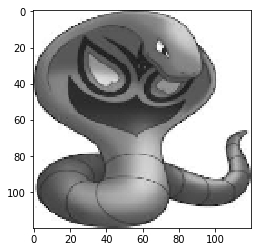

In [59]:
pd.Series(clf.predict_proba(show_example())[0], index = clf.classes_)

In [70]:
scr

0.49203187250996017

In [71]:
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
clf2
clf2.score(X_test, y_test)

0.27191235059760954

In [74]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)
y_pred3 = neigh.predict(X_test)

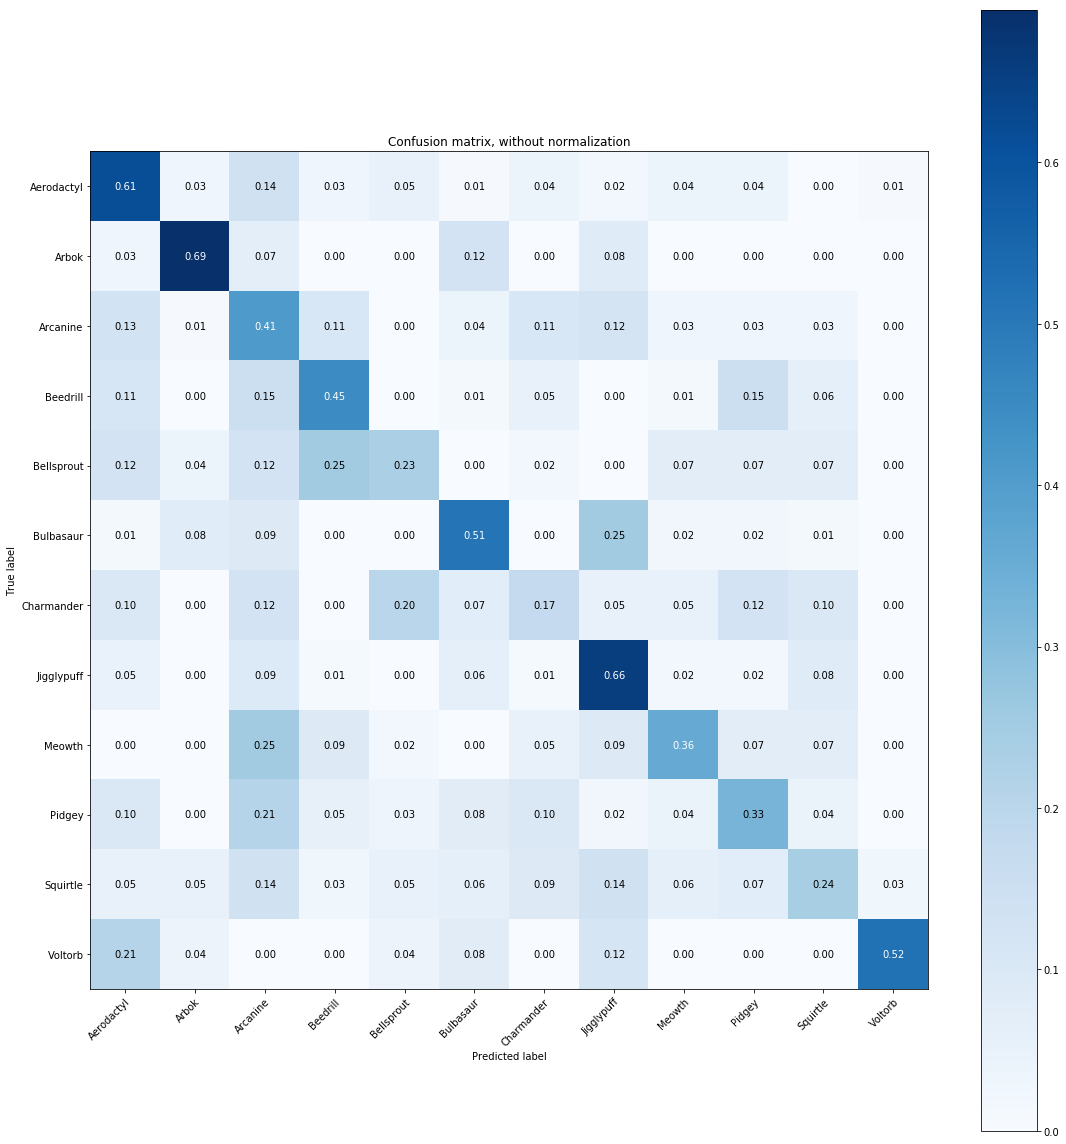

In [75]:
plot_confusion_matrix(y_test, y_pred3, classes=clf.classes_,
                      title='Confusion matrix, without normalization')



plt.show()